In [2]:
#importing necessary libraries

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)



In [3]:
#Downloading and splitting the dataset

(training_set, validation_set), dataset_info = tfds.load(
'tf_flowers',
split=['train[:70%]','train[70%:]'],
with_info=True,
as_supervised=True)
print(dataset_info)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [4]:
num_classes = dataset_info.features['label'].num_classes
im_shape = dataset_info.features['image'].shape

print(im_shape)

num_training_examples = 0
for example in training_set:
 num_training_examples += 1

num_validation_examples = 0
for example in validation_set:
 num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

(None, None, 3)
Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [5]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [6]:
#Reformatting images and creating batches

IMAGE_RES = 224

def format_image(image, label):
  #image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/.255  this gives lower accuracy in the model I tried beleive me!!~~
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1) 

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(validation_batches)

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [7]:
#Simple transfer learning from hub
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape = (IMAGE_RES, IMAGE_RES,3),trainable=False)# Also Freezed the pre-trained model

In [8]:
#Attaching a classification head

model = tf.keras.Sequential([
        feature_extractor,
        layers.Dense(num_classes) 
        #can also be done this way
        #tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
#Training the model
model.compile(
   optimizer = 'adam',
   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
   metrics=['accuracy'])

EPOCHS = 6

history = model.fit(
   train_batches,
   epochs=EPOCHS,
   validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 7s 84ms/step - loss: 0.8022 - accuracy: 0.6929 - val_loss: 0.4637 - val_accuracy: 0.8411
Epoch 2/6
81/81 [==============================] - 6s 77ms/step - loss: 0.3903 - accuracy: 0.8657 - val_loss: 0.3913 - val_accuracy: 0.8756
Epoch 3/6
81/81 [==============================] - 6s 77ms/step - loss: 0.3054 - accuracy: 0.8965 - val_loss: 0.3504 - val_accuracy: 0.8892
Epoch 4/6
81/81 [==============================] - 6s 76ms/step - loss: 0.2573 - accuracy: 0.9159 - val_loss: 0.3209 - val_accuracy: 0.8955
Epoch 5/6
81/81 [==============================] - 6s 76ms/step - loss: 0.2184 - accuracy: 0.9354 - val_loss: 0.3223 - val_accuracy: 0.8983
Epoch 6/6
81/81 [==============================] - 6s 77ms/step - loss: 0.1899 - accuracy: 0.9463 - val_loss: 0.3134 - val_accuracy: 0.9019


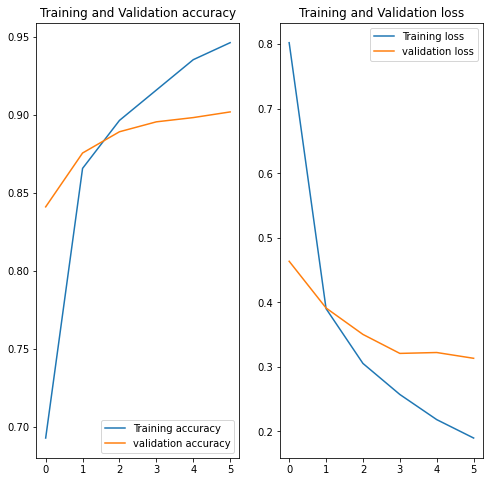

In [11]:
#Plotting validation and training graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training accuracy')
plt.plot(epochs_range, val_acc, label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training loss')
plt.plot(epochs_range, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()


In [12]:
#checking prediction

class_names = np.array(dataset_info.features['label'].names)
print(class_names)


['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [13]:
#creating an image batch amd checking prediction
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()


predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'dandelion' 'dandelion' 'roses' 'roses' 'daisy' 'tulips'
 'dandelion' 'tulips' 'tulips' 'dandelion' 'sunflowers' 'sunflowers'
 'dandelion' 'dandelion' 'dandelion' 'sunflowers' 'dandelion' 'daisy'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'roses' 'daisy' 'sunflowers'
 'tulips' 'sunflowers' 'sunflowers' 'roses' 'roses' 'daisy']


In [14]:
#printing True labels and prediction indices
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 0 0 4 4 1 2 0 2 2 0 3 3 0 0 0 3 0 4 2 3 4 3 4 1 3 2 3 3 4 4 1]
Predicted labels:  [2 0 0 4 4 1 2 0 2 2 0 3 3 0 0 0 3 0 1 2 3 4 3 4 1 3 2 3 3 4 4 1]


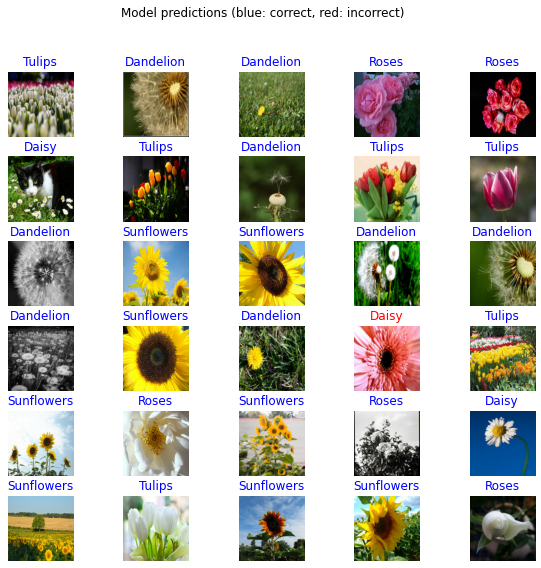

In [15]:
#Plotting model predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [18]:
#performing Transfer learning with inception model
IMAGE_RESOLUTION = 299

(training_set,validation_set), dataset_in = tfds.load(
    'tf_flowers',
    split = ['train[:70%]','train[70%:]'],
    with_info=True,
    as_supervised=True,
)

def for_i(image,label):
  image = tf.image.resize(image, (IMAGE_RESOLUTION, IMAGE_RESOLUTION))/255.0
  return image,label

train_batches=training_set.shuffle(num_training_examples//4).map(for_i).batch(BATCH_SIZE).prefetch(1)
validation_batches=validation_set.map(for_i).batch(BATCH_SIZE).prefetch(1)


URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_ex = hub.KerasLayer(URL, input_shape=(IMAGE_RESOLUTION,IMAGE_RESOLUTION,3),trainable=False)

#feature_ex.trainable = False

model_ec = tf.keras.Sequential(
    [feature_ex,
    #layers.Dense(num_classes)
    tf.keras.layers.Dense(num_classes)]
)

model_ec.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
#training the inception model
model_ec.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy']
              )

EP = 6

history_inception = model_ec.fit(
    train_batches,
    epochs=EP,
    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 15s 189ms/step - loss: 0.2694 - accuracy: 0.9093 - val_loss: 0.2839 - val_accuracy: 0.8992
Epoch 2/6
81/81 [==============================] - 15s 186ms/step - loss: 0.2173 - accuracy: 0.9311 - val_loss: 0.2704 - val_accuracy: 0.9001
Epoch 3/6
81/81 [==============================] - 15s 188ms/step - loss: 0.1885 - accuracy: 0.9428 - val_loss: 0.2863 - val_accuracy: 0.8955
Epoch 4/6
81/81 [==============================] - 15s 185ms/step - loss: 0.1705 - accuracy: 0.9556 - val_loss: 0.2755 - val_accuracy: 0.9019
Epoch 5/6
81/81 [==============================] - 15s 182ms/step - loss: 0.1532 - accuracy: 0.9603 - val_loss: 0.2792 - val_accuracy: 0.8919
Epoch 6/6
81/81 [==============================] - 15s 184ms/step - loss: 0.1417 - accuracy: 0.9630 - val_loss: 0.2717 - val_accuracy: 0.8992


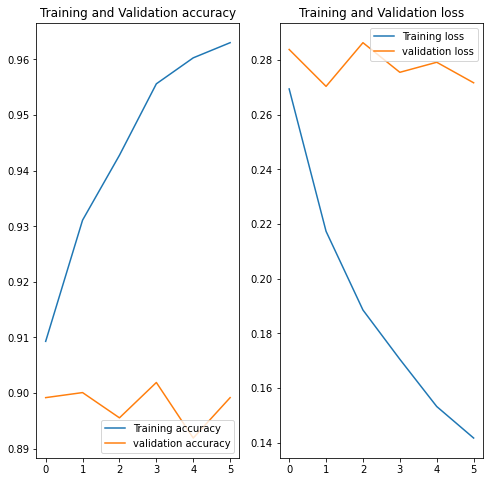

In [24]:
#plotting the inception model sets of accuracy and loss
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']

loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

epochs_range = range(EP)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training accuracy')
plt.plot(epochs_range, val_acc, label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training loss')
plt.plot(epochs_range, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()

In [25]:
#checking prediction with inception model
class_name=np.array(dataset_in.features['label'].names)
print(class_name)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [27]:
#creating image batches and checking them with inception model
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()


predicted_batch = model_ec.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_name = class_name[predicted_ids]

print(predicted_class_name)

['roses' 'dandelion' 'daisy' 'tulips' 'daisy' 'tulips' 'dandelion'
 'sunflowers' 'daisy' 'dandelion' 'sunflowers' 'sunflowers' 'roses'
 'daisy' 'roses' 'daisy' 'sunflowers' 'dandelion' 'daisy' 'dandelion'
 'dandelion' 'dandelion' 'daisy' 'sunflowers' 'roses' 'sunflowers'
 'dandelion' 'tulips' 'roses' 'tulips' 'daisy' 'dandelion']


In [28]:
#printing true labels and predicted indices
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [4 0 1 2 1 2 0 3 1 0 3 3 4 1 4 1 3 0 1 0 0 0 1 3 4 3 0 2 4 2 1 0]
Predicted labels:  [4 0 1 2 1 2 0 3 1 0 3 3 4 1 4 1 3 0 1 0 0 0 1 3 4 3 0 2 4 2 1 0]


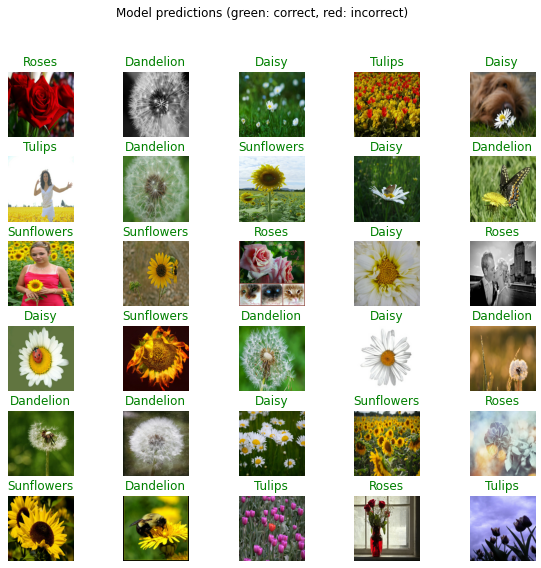

In [29]:
#plotting Inception model prediction for better comparison between two models
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "green" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_name[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")